In [20]:
from cosmikyu import maps, config
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from pixell import enmap, enplot

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")



%matplotlib inline

In [2]:
output_dir = config.default_data_dir
def output_path(x):
    return os.path.join(output_dir, x)

res_arcmin = 0.5
shape = (256, 256)
stamp_dir = output_path("stamp_{}arcmin_{}x{}".format(res_arcmin, shape[0], shape[1]))

SS = maps.StampedSky(stamp_dir, res_arcmin, shape)

In [3]:
class StampedSkyDataSet(Dataset):
    def __init__(self, root_dir, num_sim, res_arcmin, fg_type, freq, shape, transform=None):
        self.stamped_sky = maps.StampedSky(root_dir, res_arcmin, shape)
        self.freq = freq
        self.fg_rfuncs = {
            'ir_pts': self.stamped_sky.get_cib,
            'ksz': self.stamped_sky.get_ksz,
            'rad_pts': self.stamped_sky.get_radio,
            'tsz': self.stamped_sky.get_tsz   
        }
        self.fg_type = fg_type
        self.rfunc = self.fg_rfuncs[self.fg_type]    
        self.transform = transform
        self.num_sim = num_sim
        
    
    def __len__(self):
        return self.num_sim
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        fg_map = self.rfunc(self.freq, idx, False)
        sample = {'data': np.array(fg_map), 'wcs': fg_map.wcs.copy()}
        if self.transform:
            sample = self.transform(sample)
         
        return sample
        
    

In [5]:
SSDS = StampedSkyDataSet(stamp_dir, 3000, res_arcmin, 'ir_pts', 30, (256,256))

In [70]:
class LogScale(object):
    def __call__(self, sample):
        data = sample['data']
        sign = np.sign(data)
        sample['data'] = np.nan_to_num(sign*np.log(np.abs(data)))
        return sample
    
    
class Normalize(object):
    def __init__(self, meta, scale='log'):
        assert(scale in ['linear', 'log'])
        
        if scale == 'log':
            sign = np.sign(meta)
            meta = np.nan_to_num(sign*np.log(np.abs(meta)))
        
        self.scale = scale
        self.meta = meta
    
    def __call__(self, sample):
        if self.scale == 'log':
            data = sample['data']
            sign = np.sign(data)
            sample['data'] = np.nan_to_num(sign*np.log(np.abs(data)))
        
        mmean, mstd, mmax, mmin = self.meta 
        sample['data'] = (sample['data']-mmean)/(mmax-mmin)
        
        return sample  
    
class UnNormalize(Normalize):
    def __init__(self, meta, scale='log'):
        super().__init__(meta, scale)
    
    def __call__(self, sample):
        mmean, mstd, mmax, mmin = self.meta 
        sample['data'] = sample['data']*(mmax-mmin)+mmean
        
        if self.scale == 'log':
            data = sample['data']
            sign = np.sign(data)
            sample['data'] = np.nan_to_num(sign*np.exp(np.abs(data)))
        
        return sample
    
class ToEnmap(object):
    def __call__(self, sample):
        return enmap.enmap(sample['data'], wcs=sample['wcs'])

296.11116522107693 -19.820681509141828
296.1111652210769 -306.9379546954343


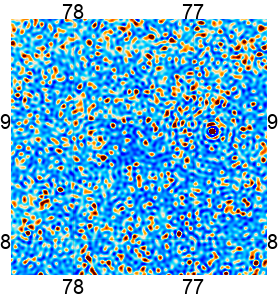

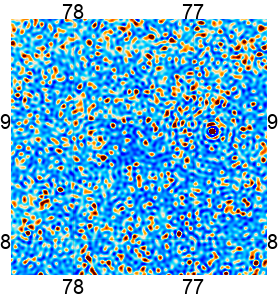

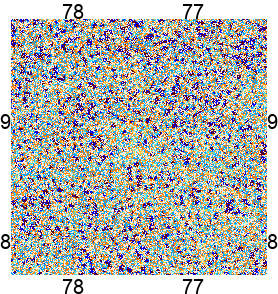

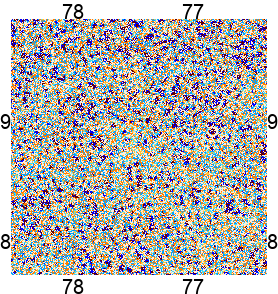

In [71]:
LS = LogScale()
np.mean(LS.__call__(SSDS[0])['data'])



meta = np.loadtxt('/gpfs/home/dongwhan/workspace/cosmikyu/data/ir_pts/030_meta.txt')
omap = enmap.enmap(SSDS[0]['data'], wcs=SSDS[0]['wcs'])
oloc = np.where(omap < 0)
NN = Normalize(meta)
UN = UnNormalize(meta)
TE = ToEnmap()

fmap = TE.__call__(UN.__call__(NN.__call__(SSDS[0])))
floc = np.where(fmap > 0)
print(np.max(omap), np.min(omap))
print(np.max(fmap), np.min(fmap))
enplot.pshow(omap, downgrade=1)
enplot.pshow(fmap, downgrade=1)
enplot.pshow(omap-fmap, downgrade=1)
oomap = omap.copy(); oomap[oloc] = 0
ffmap = fmap.copy(); ffmap[oloc] = 0


enplot.pshow(oomap-ffmap, downgrade=1)

In [67]:
a = -1*np.exp(1); print(a)
sign = np.sign(a); print(sign)
b = np.log(np.abs(a)); print(b)
c = sign*b; print(c)
sign2 = np.sign(c); print(sign2)
d = np.exp(np.abs(c)); print(d)
e = sign*d; print(e)
print((a-e)/e)



-2.718281828459045
-1.0
1.0
-1.0
-1.0
2.718281828459045
-2.718281828459045
-0.0
